In [10]:
!pip install "numpy<1.24.0"

In [11]:
import numpy
print(numpy.__version__)

1.23.5


In [12]:
CLONE_URL = f"https://github.com/MaurizioFD/RecSys_Course_AT_PoliMi.git"
get_ipython().system(f"git clone {CLONE_URL}")

import sys
sys.path.append("RecSys_Course_AT_PoliMi")

Cloning into 'RecSys_Course_AT_PoliMi'...
remote: Enumerating objects: 1502, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 1502 (delta 114), reused 233 (delta 100), pack-reused 1255
Receiving objects: 100% (1502/1502), 50.99 MiB | 21.35 MiB/s, done.
Resolving deltas: 100% (845/845), done.


In [13]:
import time
from matplotlib import pyplot
import pandas as pd
import numpy as np
import scipy.sparse as sps
import random as rnd

from scipy.sparse import *

urm_path = '/kaggle/input/ressysdata/data_train.csv'
urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

urm_all_df.head(10)

print ("The number of interactions is {}".format(len(urm_all_df)))

userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

# Remove empty profiles

# Remove empty IDs
mapped_id, original_id = pd.factorize(urm_all_df["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(urm_all_df["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)



# Let's create the mapping from items indices to original item_ids
item_index_to_original_ID = pd.Series(item_original_ID_to_index.index,index = item_original_ID_to_index.values)



original_item_ID = 125
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))


urm_all_df["UserID"] = urm_all_df["UserID"].map(user_original_ID_to_index)
urm_all_df["ItemID"] = urm_all_df["ItemID"].map(item_original_ID_to_index)
urm_all_df.head(n=10)

userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

#urm_all = urm_all.tocsr()
#urm_all

The number of interactions is 478730
Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %
New index for item 125 is 93
Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [ ]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))

val_mask = np.logical_not(train_mask)

urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))

In [14]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_algorithm(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at,exclude_seen=True)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.10f}, Recall = {:.10f}, MAP = {:.10f}".format(
        cumulative_precision, cumulative_recall, MAP))
    return MAP, mean_precision, mean_recall

# Preparing for training

In [15]:
train_n_interactions = urm_train.nnz

n_users, n_items = urm_train.shape
print(f"The num of users is {n_users}")
print(f"The num of items is {n_items}")

NameError: name 'urm_train' is not defined

# Evaluate the trained model

In [16]:
class EASERRecommender(object):

    def __init__(self, URM, model):
        self.URM = URM
        self.model = model

    def recommend(self, user_id, at=None, exclude_seen=True, users_not_in_train=[]):
        # Check if user_id is a valid index
        if user_id < 0 or user_id >= self.URM.shape[0]:
            print(f"Invalid user_id: {user_id}")
            return

        # Check if user_id not in train use the topRec
        if user_id in users_not_in_train:
            return ["517 189 44 0 284 808 285 1 557 1266"]

        # compute the scores using the fitted model
        scores = self.model._compute_score_W_dense(user_id)[0]

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

In [ ]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender

model = EASE_R_Recommender(urm_train)
model.fit(topK = 150,l2_norm = 1e2)

In [ ]:
# normalize_matrix = True
#topK = 100
#l2_norm = 5e1

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 100
#l2_norm = 5e1

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 150
#l2_norm = 5e1

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 150
#l2_norm = 5e2

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 250
#l2_norm = 1e2

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 100
#l2_norm = 1e2

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 150
#l2_norm = 1e1

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 150
#l2_norm = 1e2


recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 150
#l2_norm = 1e3

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

In [ ]:
#topK = 200
#l2_norm = 1e3

recommender_easer = EASERRecommender(urm_train,model)
map, mp,mr = evaluate_algorithm(urm_val,recommender_easer)
print(f"MAP@10 on val is {map}")

# K-fold Cross-Validatoin

**Define the k data partitions for k-folds cross-validation**

In [17]:
from sklearn.model_selection import KFold

n_interactions = urm_all.nnz
num_folds = 5

kf = KFold(n_splits=num_folds,  shuffle = True)
data_folds = []
indices = np.arange(n_interactions)
for train_inc, val_inc in kf.split(indices):
  train_mask = np.full(n_interactions,True)
  train_mask[val_inc] = False
  val_mask = np.logical_not(train_mask)

  fold_urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))
  fold_urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})


**Implement the iterative random hyperparameter search with k-fold cross-validation**

In [ ]:
from scipy.stats import loguniform

rnd_l2_norm = np.array(list(set(loguniform.rvs(1, 1e3, size=6).astype(float))))
rnd_topK = np.array(list(set(loguniform.rvs(10, 300, size=6).astype(int))))

print(f"L2 norm:{rnd_l2_norm}")
print(f"TopK:{rnd_topK}")

In [18]:
# Recover maually the hyperparamers values from the random sampling 
rnd_l2_norm = np.array([ 64.5231847,133.12475561,751.34079104,430,20.79725095,27.6050448 ])
rnd_topK = np.array([131, 36, 234,  79,  28])

*L2_norm*

In [19]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender

In [23]:
import gc

In [26]:
# Continue evaluating the hyperparameters with CV 

default_topK = 150

hyperparameter_search_rnd = pd.DataFrame(columns = ["l2_norm", "MAP"])
hyperparameter_search_rnd["l2_norm"] = rnd_l2_norm
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="l2_norm")


for index in hyperparameter_search_rnd.index[2:]:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = EASE_R_Recommender(fold['train'])
      recommender.fit(topK = default_topK,l2_norm=hyperparameter_search_rnd.loc[index,"l2_norm"])
      recommender_easer = EASERRecommender(fold['train'],recommender)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender_easer)
      folds_map.append(map)
        
      # Delete the recommender object to save memory
      del recommender_easer
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"l2_norm"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
EASE_R_Recommender: URM Detected 215 ( 1.7%) users with no interactions.
EASE_R_Recommender: URM Detected 126 ( 0.6%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 8.15 min
Recommender results are: Precision = 969.5000000001, Recall = 1432.5788966635, MAP = 0.0823940386
Fold 1 evaluations started
EASE_R_Recommender: URM Detected 226 ( 1.8%) users with no interactions.
EASE_R_Recommender: URM Detected 114 ( 0.5%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 8.37 min
Recommender results are: Precision = 937.8000000001, Recall = 1395.9232885256, MAP = 0.0791314796
Fold 2 evaluations started
EASE_R_Recommender: URM Detected 229 ( 1.8%) users with no interactions.
EASE_R_Recommender: URM Detected 110 ( 0.5%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 8.11 min
Recommend

      l2_norm       MAP
4   20.797251  0.080263
5   27.605045  0.080549
0   64.523185  0.080412
1  133.124756  0.078608
3  430.000000  0.073474
2  751.340791  0.070552


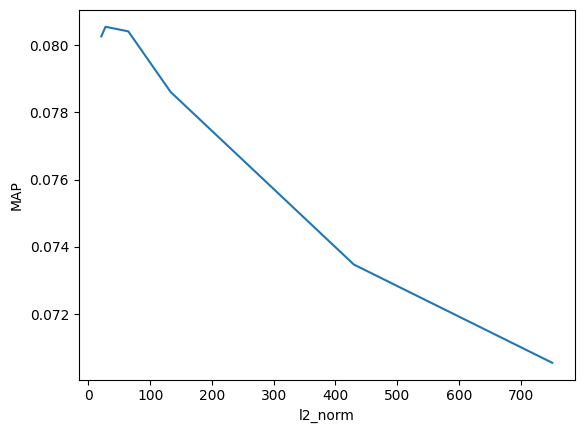

In [35]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["l2_norm"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('l2_norm')
pyplot.show()

In [36]:
best_l2_norm_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_l2_norm_value

l2_norm    27.605045
MAP         0.080549
Name: 5, dtype: object

*topK*

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["l2_norm", "TopK", "MAP"])
hyperparameter_search_rnd["TopK"] = rnd_topK
hyperparameter_search_rnd["l2_norm"] = best_l2_norm_value["l2_norm"]


for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = EASE_R_Recommender(fold['train'])
      recommender.fit(l2_norm=best_l2_norm_value["l2_norm"], topK=hyperparameter_search_rnd.loc[index,"TopK"])
      recommender_easer = EASERRecommender(fold['train'],recommender)
      map, mp,mr = evaluate_algorithm(fold['val'],recommender_easer)
      folds_map.append(map)
                
      # Delete the recommender object to save memory
      del recommender_easer
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"topK"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

print(hyperparameter_search_rnd)

Fold 0 evaluations started
EASE_R_Recommender: URM Detected 215 ( 1.7%) users with no interactions.
EASE_R_Recommender: URM Detected 126 ( 0.6%) items with no interactions.
EASE_R_Recommender: Fitting model... 


In [ ]:
pyplot.plot(hyperparameter_search_rnd["TopK"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [ ]:
best_topK = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_topK